# Other tries with unsupervised Deep learning (part 1)

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import librosa
import librosa.display
import IPython.display as ipd
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from sklearn.model_selection import train_test_split
import pywt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D,Conv1D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import to_categorical
from matplotlib import cm
%matplotlib inline
from sklearn import metrics
import tensorflow as tf
import itertools


#Constant used throughout the notebook
PATH_TRAINING_DATASET = r"C:\Users\sylv_\Desktop\audio for asd"


In [2]:
def build_dataframe(machine_str = 'valve'):
    #Get list of files in train and test directory
    path_train_folder = PATH_TRAINING_DATASET + "\\dev_" + machine_str + "\\" + machine_str + "\\train"
    path_test_folder = PATH_TRAINING_DATASET  + "\\dev_" + machine_str + "\\" + machine_str + "\\test"

    train_files = [f for f in os.listdir(path_train_folder)]
    test_files = [f for f in os.listdir(path_test_folder)]

    #Get list of dictionnary for creating DataFrame
    list_dict_file = []

    #Loop through filenames
    for filename in train_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_train_folder + "\\" + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:])        #.split('.')[0]  --> want to keep the complete suffix
        })

    #Loop through filenames
    for filename in test_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_test_folder  + "\\" + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:])     #.split('.')[0]  --> want to keep the complete suffix
        })
        
    return pd.DataFrame(list_dict_file)


def sound_from_file(filename, machine_str = 'valve', dataset = 'train'):
    df = build_dataframe(machine_str)
    path = PATH_TRAINING_DATASET + "\\dev_" + machine_str + "\\" + machine_str + "\\" + dataset + "\\" + filename
    return df[df['filepath']==path].iloc[0]
    


df_fan = build_dataframe('fan')
df_valve = build_dataframe('valve')
df_bearing = build_dataframe('bearing')
df_slider = build_dataframe('slider')
df_car = build_dataframe('ToyCar')
df_train = build_dataframe('ToyTrain')
df_gearbox = build_dataframe('gearbox')

df_fan.info()
df_fan.head()
df_slider.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filepath    3600 non-null   object
 1   filename    3600 non-null   object
 2   section     3600 non-null   int64 
 3   domain_env  3600 non-null   object
 4   dir         3600 non-null   object
 5   sound_type  3600 non-null   object
 6   id          3600 non-null   object
 7   suffix      3600 non-null   object
dtypes: int64(1), object(7)
memory usage: 225.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filepath    3600 non-null   object
 1   filename    3600 non-null   object
 2   section     3600 non-null   int64 
 3   domain_env  3600 non-null   object
 4   dir         3600 non-null   object
 5   sound_type  3600 non-null   object
 6   id         

In [3]:
def load_audio(audio_path):
    return librosa.load(audio_path, sr=None)

def logMelSpectrogram(audio, fe, dt):
    # Spectrogramme
    stfts = np.abs(librosa.stft(audio,
                                n_fft=int(dt*fe),
                                hop_length=int(dt*fe),
                                center=True
                                )).T
    num_spectrogram_bins = stfts.shape[-1]
    # Filtre de MEL
    linear_to_mel_weight_matrix = librosa.filters.mel(
        sr=fe,
        n_fft=int(dt*fe) + 1,
        n_mels=num_spectrogram_bins,
    ).T

    # Application du filtre au spectrogramme
    mel_spectrograms = np.tensordot(
        stfts,
        linear_to_mel_weight_matrix,
        1
    )
    return np.log(mel_spectrograms + 1e-6)

def load_data(audio_path, dt=0.03):
    X_audio = []
    Y_audio=[]
    Z_audio=[]
    for i, a_path in enumerate(audio_path):
        # On charge les fichiers audio depuis les chemins
        data, fe = load_audio(a_path)

        # On applique la fonction logMelSpectrogram.
        #spectre_audio = logMelSpectrogram(data, fe, dt)
        spectre_ft = np.abs(librosa.stft(data, n_fft= int(fe*dt), hop_length = int(fe*dt)))
        #X_audio.append(spectre_audio)
        Y_audio.append(spectre_ft)
    a_audio = np.expand_dims(Y_audio, 3)
        #coeff, freq = pywt.cwt(data,scales=np.arange(1,129), wavelet='morl')
        #Z_audio.append(coeff)
    return np.array(a_audio)

## Essai Autoencoder simple 1 machine-valve- FT to FT-bottleneck: 20

In [ ]:
df0 = df_valve # to change for other machines
df0 = df0.replace(to_replace = ['normal', 'anomaly'], value = [1, 0])
X= df0.drop(['sound_type'],1)
y=df0.sound_type

In [ ]:
X_normal= X[y == 1]
X_anomaly= X[y == 0]

X_train_normal,X_test_normal = train_test_split(X_normal["filepath"] , test_size=0.2)

X_train_normal = load_data(X_train_normal)
X_test_normal = load_data(X_test_normal)
print(X_train_normal.shape)
print(X_test_normal.shape)

In [ ]:
X_train_normal_2= np.pad(X_train_normal, pad_width=((0,0),(0,7),(0,2),(0,0)), constant_values=0)
X_test_normal_2= np.pad(X_test_normal, pad_width=((0,0),(0,7),(0,2),(0,0)), constant_values=0)
print(X_train_normal_2.shape)

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(X_train_normal_2,X_train_normal_2, 20)
test_gen = DataGenerator(X_test_normal_2,X_test_normal_2,20)

In [ ]:
from tensorflow.keras.layers import UpSampling2D,Reshape

autoencoder= Sequential()

encodeur_1= Conv2D(64, kernel_size=(3, 3), activation='linear', input_shape=X_train_normal_2.shape[1:])
encodeur_2= MaxPooling2D(pool_size=(2, 2))
encodeur_3= Conv2D(32, kernel_size=(3, 3), activation='linear')
encodeur_4= MaxPooling2D(pool_size=(2, 2))
encodeur_5= Dropout(0.25)
encodeur_6= Flatten()

encodeur_7= Dense(5, activation='linear')
encodeur_8= Dense(5, activation='relu')
decodeur_0= Dense(166656, activation='linear')

decodeur_1= Reshape((62, 84, 32))
decodeur_2= UpSampling2D((2, 2))
decodeur_3= Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same')
decodeur_4= UpSampling2D((2, 2))

decodeur_5= Conv2D(1, kernel_size=(3, 3), activation='linear', padding='same')



autoencoder.add(encodeur_1)
autoencoder.add(encodeur_2)
autoencoder.add(encodeur_3)
autoencoder.add(encodeur_4)
autoencoder.add(encodeur_5)
autoencoder.add(encodeur_6)
autoencoder.add(encodeur_7)
autoencoder.add(encodeur_8)

autoencoder.add(decodeur_0)
autoencoder.add(decodeur_1)
autoencoder.add(decodeur_2)
autoencoder.add(decodeur_3)
autoencoder.add(decodeur_4)
autoencoder.add(decodeur_5)


autoencoder.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
autoencoder.summary()

In [ ]:
history_autoencoder=autoencoder.fit(train_gen, epochs=8, validation_data= test_gen)

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(history_autoencoder.history['loss'], linewidth=2, label='Train')
plt.plot(history_autoencoder.history['val_loss'], linewidth=2, label='Validation')

plt.xlabel('Epoque')
plt.ylabel('Perte')
plt.title('Evolution de la fonction de perte', fontsize=15)
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.losses import mean_squared_error

X_train_normal_pred=autoencoder.predict(train_gen, 5)
mse_train=mean_squared_error(X_train_normal_2,X_train_normal_pred)
print(np.percentile(mse_train,q=95))

X_test_normal_pred=autoencoder.predict(test_gen,5)
mse_test=mean_squared_error(X_test_normal_2,X_test_normal_pred)
print(np.percentile(mse_test,q=95))

In [ ]:
X_anomaly= X[y == 0]
X_anomaly = load_data(X_anomaly["filepath"])

X_anomaly_2=np.pad(X_anomaly, pad_width=((0,0),(0,7),(0,2),(0,0)), constant_values=0)

X_anomaly_pred=autoencoder.predict(X_anomaly_2)
mse2=mean_squared_error(X_anomaly_2,X_anomaly_pred)
print(np.percentile(mse2,q=95))

In [ ]:
mse_train.shape

In [ ]:
#Loss of test split training samples
mse_losses_train_normal =[]
for data in mse_train:
    mse=1/((np.array(data).max()- np.array(data).mean()) / (np.array(data).max()- np.array(data).min()))
    mse_losses_train_normal.append(mse)

In [ ]:
#Loss of test normal samples
mse_losses_test_normal = []
for data in mse_test:
    mse=1/((np.array(data).max()- np.array(data).mean()) / (np.array(data).max()- np.array(data).min()))
    mse_losses_test_normal.append(mse)

In [ ]:
#Loss of anormal test samples
mse_losses_test_anomaly = []
for data in mse2:
    mse=1/((np.array(data).max()- np.array(data).mean()) / (np.array(data).max()- np.array(data).min()))
    mse_losses_test_anomaly.append(mse)

In [ ]:
#     #Check length of list
#     print(len(mse_losses_test_split_from_training))
#     print(len(mse_losses_test_normal))
#     print(len(mse_losses_test_anomaly))

#Plot the losses
plt.figure(figsize=(10,4))
plt.plot(mse_losses_train_normal, label='loss normal train samples')
plt.plot(mse_losses_test_normal, label='loss normal test samples')
plt.plot(mse_losses_test_anomaly, label='loss anomaly test samples')
plt.title('Mse losses of different type of samples')
plt.legend()
plt.xlim(0,300)
plt.ylim(1,1.01)
plt.show()

In [ ]:
#Plot the losses
plt.figure(figsize=(10,4))
plt.plot(np.sort(mse_losses_train_normal), label='loss normal train samples')
plt.plot(np.sort(mse_losses_test_normal), label='loss normal test samples')
plt.plot(np.sort(mse_losses_test_anomaly), label='loss anomaly test samples')
plt.title('Mse losses of different type of samples')
plt.legend()
plt.xlim(0,2640)
plt.ylim(1,1.02)
plt.show()

In [ ]:
X_train_normal_pred=[]
for sample in X_train_normal_2:
    sample_exp = np.expand_dims(sample, 0)
    sample_pred=autoencoder.predict(sample_exp, verbose=0)
    X_train_normal_pred.append(sample_pred)
X_train_normal_pred_2=np.squeeze(X_train_normal_pred,1)
print(np.shape(X_train_normal_pred_2))

X_test_normal_pred=[]
for sample in X_test_normal_2:
    sample_exp = np.expand_dims(sample, 0)
    sample_pred=autoencoder.predict(sample_exp, verbose=0)
    X_test_normal_pred.append(sample_pred)
X_test_normal_pred_2=np.squeeze(X_test_normal_pred,1)
print(np.shape(X_test_normal_pred_2))

In [ ]:
X_anomaly= X[y == 0]
X_anomaly = load_data(X_anomaly["filepath"])

X_anomaly_2=np.pad(X_anomaly, pad_width=((0,0),(0,7),(0,2),(0,0)), constant_values=0)
X_anomaly_pred=[]
for sample in X_anomaly_2:
    sample_exp = np.expand_dims(sample, 0)
    sample_pred=autoencoder.predict(sample_exp, verbose=0)
    X_anomaly_pred.append(sample_pred)
X_anomaly_pred_2=np.squeeze(X_anomaly_pred,1)
print(np.shape(X_anomaly_pred_2))  

In [ ]:
liste_anomaly=[]
for sample, sample_pred in zip(X_anomaly_2, X_anomaly_pred_2):
    maxi=(np.abs(sample - sample_pred).mean(axis=1).max()*2)
    liste_anomaly.append(maxi)
    
liste_test=[]
for sample, sample_pred in zip(X_test_normal_2, X_test_normal_pred_2):
    maxi=(np.abs(sample - sample_pred).mean(axis=1).max()*2)
    liste_test.append(maxi)
    
liste_train=[]
for sample, sample_pred in zip(X_train_normal_2, X_train_normal_pred_2):
    maxi=(np.abs(sample - sample_pred).mean(axis=1).max()*2)
    liste_train.append(maxi)

In [ ]:
#Plot the losses
plt.figure(figsize=(10,4))
plt.plot(liste_train, label='loss normal train samples')
plt.plot(liste_test, label='loss normal test samples')
plt.plot(liste_anomaly, label='loss anomaly test samples')
plt.title('Mse losses of different type of samples')
plt.legend()
plt.xlim(0,400)
plt.ylim(0,0.5)
plt.show()

In [ ]:
#Plot the losses
plt.figure(figsize=(10,4))
plt.plot(np.sort(liste_train), label='loss normal train samples')
plt.plot(np.sort(liste_test), label='loss normal test samples')
plt.plot(np.sort(liste_anomaly), label='loss anomaly test samples')
plt.title('Mse losses of different type of samples')
plt.legend()
plt.xlim(0,2640)
plt.ylim(0,0.9)
plt.show()

#### nous observons que l'on peut distinguer les anomalies d'une bonne partie des echantillons normales mais c'est loin d'etre suffisant notamment face au echantillon test normaux et une bonne moitié des train normaux

## Essai autoencoder- logFT + augmentation résolution

In [ ]:
## relaunch kernel and 3 first cell to avoid memory saturation

In [4]:
def load_data_2(audio_path, dt=0.03):
    Y_audio=[]
    for i, a_path in enumerate(audio_path):
        # On charge les fichiers audio depuis les chemins
        data, fe = load_audio(a_path)
        spectre_ft = np.abs(librosa.stft(data, n_fft= int(fe*dt), hop_length = int(fe*dt)))
        Y_soundb1 = np.abs(spectre_ft) ** 2
        Y_log_soundb1 = librosa.power_to_db(Y_soundb1)
        Y_audio.append(Y_log_soundb1)
    a_audio = np.expand_dims(Y_audio, 3)
    return np.array(a_audio)

def load_data_3(audio_path, dt=0.03):
    Y_audio=[]
    for i, a_path in enumerate(audio_path):
        # On charge les fichiers audio depuis les chemins
        data, fe = load_audio(a_path)
        spectre_ft = np.abs(librosa.stft(data, n_fft= int(fe*dt/4), hop_length = int(fe*dt*4)))
        Y_soundb1 = np.abs(spectre_ft) ** 2
        Y_log_soundb1 = librosa.power_to_db(Y_soundb1)
        Y_audio.append(Y_log_soundb1)
    a_audio = np.expand_dims(Y_audio, 3)
    return np.array(a_audio)

In [5]:
df0 = df_valve # to change for other machines
df0 = df0.replace(to_replace = ['normal', 'anomaly'], value = [1, 0])
X= df0.drop(['sound_type'],1)
y=df0.sound_type
X_normal= X[y == 1]
X_anomaly= X[y == 0]

X_train_normal,X_test_normal = train_test_split(X_normal["filepath"] , test_size=0.2)

X_train_normal_hr = load_data_2(X_train_normal)
X_test_normal_hr = load_data_2(X_test_normal)
X_train_normal_lr = load_data_3(X_train_normal)
X_test_normal_lr = load_data_3(X_test_normal)

C:\Users\sylv_\AppData\Local\Temp\ipykernel_12368\2740062068.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X= df0.drop(['sound_type'],1)


In [6]:
print(X_train_normal_hr.shape)
print(X_test_normal_lr.shape)

(2640, 241, 334, 1)
(660, 61, 84, 1)


In [7]:
X_train_normal_hr_2= np.pad(X_train_normal_hr, pad_width=((0,0),(0,7),(0,2),(0,0)), constant_values=0)
X_test_normal_hr_2= np.pad(X_test_normal_hr, pad_width=((0,0),(0,7),(0,2),(0,0)), constant_values=0)
X_train_normal_lr_2= np.pad(X_train_normal_lr, pad_width=((0,0),(0,1),(0,0),(0,0)), constant_values=0)
X_test_normal_lr_2= np.pad(X_test_normal_lr, pad_width=((0,0),(0,1),(0,0),(0,0)), constant_values=0)
print(X_train_normal_hr_2.shape)
print(X_train_normal_lr_2.shape)

(2640, 248, 336, 1)
(2640, 62, 84, 1)


In [8]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen2 = DataGenerator(X_train_normal_lr_2,X_train_normal_hr_2, 20)
test_gen2 = DataGenerator(X_test_normal_lr_2,X_test_normal_hr_2,20)

In [9]:
from tensorflow.keras.layers import UpSampling2D,Reshape

autoencoder2= Sequential()

encodeur_1= Conv2D(64, kernel_size=(3, 3), activation='linear', input_shape=X_train_normal_lr_2.shape[1:])
encodeur_2= MaxPooling2D(pool_size=(2, 2))
encodeur_3= Conv2D(32, kernel_size=(3, 3), activation='linear')
encodeur_4= MaxPooling2D(pool_size=(2, 2))
encodeur_5= Dropout(0.25)
encodeur_6= Flatten()

encodeur_7= Dense(15, activation='linear')
encodeur_8= Dense(15, activation='relu')
decodeur_0= Dense(166656, activation='linear')

decodeur_1= Reshape((62, 84, 32))
decodeur_2= UpSampling2D((2, 2))
decodeur_3= Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same')
decodeur_4= UpSampling2D((2, 2))

decodeur_5= Conv2D(1, kernel_size=(3, 3), activation='linear', padding='same')



autoencoder2.add(encodeur_1)
autoencoder2.add(encodeur_2)
autoencoder2.add(encodeur_3)
autoencoder2.add(encodeur_4)
autoencoder2.add(encodeur_5)
autoencoder2.add(encodeur_6)
autoencoder2.add(encodeur_7)
autoencoder2.add(encodeur_8)

autoencoder2.add(decodeur_0)
autoencoder2.add(decodeur_1)
autoencoder2.add(decodeur_2)
autoencoder2.add(decodeur_3)
autoencoder2.add(decodeur_4)
autoencoder2.add(decodeur_5)


autoencoder2.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])
autoencoder2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 82, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 41, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 39, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 19, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 19, 32)        0         
                                                                 
 flatten (Flatten)           (None, 8512)              0

In [10]:
history_autoencoder2=autoencoder2.fit(train_gen2, epochs=8, validation_data= test_gen2)

Epoch 1/8
132/132 [==============================] - 9s 39ms/step - loss: 77.4666 - accuracy: 0.0264 - val_loss: 44.9931 - val_accuracy: 0.0314
Epoch 2/8
132/132 [==============================] - 5s 38ms/step - loss: 46.0247 - accuracy: 0.0307 - val_loss: 44.6030 - val_accuracy: 0.0326
Epoch 3/8
132/132 [==============================] - 5s 38ms/step - loss: 43.5046 - accuracy: 0.0283 - val_loss: 41.1821 - val_accuracy: 0.0297
Epoch 4/8
132/132 [==============================] - 5s 38ms/step - loss: 42.1414 - accuracy: 0.0292 - val_loss: 41.8300 - val_accuracy: 0.0314
Epoch 5/8
132/132 [==============================] - 5s 38ms/step - loss: 41.9950 - accuracy: 0.0295 - val_loss: 45.2097 - val_accuracy: 0.0279
Epoch 6/8
132/132 [==============================] - 5s 38ms/step - loss: 41.4841 - accuracy: 0.0295 - val_loss: 40.1381 - val_accuracy: 0.0306
Epoch 7/8
132/132 [==============================] - 5s 38ms/step - loss: 41.0003 - accuracy: 0.0304 - val_loss: 39.9947 - val_accuracy:

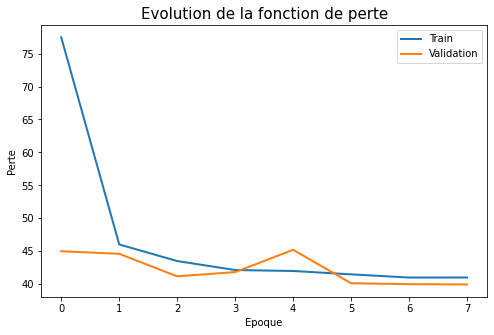

In [11]:
plt.figure(figsize=(8, 5))

plt.plot(history_autoencoder2.history['loss'], linewidth=2, label='Train')
plt.plot(history_autoencoder2.history['val_loss'], linewidth=2, label='Validation')

plt.xlabel('Epoque')
plt.ylabel('Perte')
plt.title('Evolution de la fonction de perte', fontsize=15)
plt.legend()
plt.show()

In [18]:
X_train_normal_pred=[]
for sample in X_train_normal_lr_2:
    sample_exp = np.expand_dims(sample, 0)
    sample_pred=autoencoder2.predict(sample_exp, verbose=0)
    X_train_normal_pred.append(sample_pred)
X_train_normal_pred_2=np.squeeze(X_train_normal_pred,1)
print(np.shape(X_train_normal_pred_2))

X_test_normal_pred=[]
for sample in X_test_normal_lr_2:
    sample_exp = np.expand_dims(sample, 0)
    sample_pred=autoencoder2.predict(sample_exp, verbose=0)
    X_test_normal_pred.append(sample_pred)
X_test_normal_pred_2=np.squeeze(X_test_normal_pred,1)
print(np.shape(X_test_normal_pred_2))

(2640, 248, 336, 1)
(660, 248, 336, 1)


In [20]:
X_anomaly= X[y == 0]
X_anomaly_hr = load_data_2(X_anomaly["filepath"])
X_anomaly_lr = load_data_3(X_anomaly["filepath"])
X_anomaly_hr_2=np.pad(X_anomaly_hr, pad_width=((0,0),(0,7),(0,2),(0,0)), constant_values=0)
X_anomaly_lr_2=np.pad(X_anomaly_lr, pad_width=((0,0),(0,1),(0,0),(0,0)), constant_values=0)

X_anomaly_pred=[]
for sample in X_anomaly_lr_2:
    sample_exp = np.expand_dims(sample, 0)
    sample_pred=autoencoder2.predict(sample_exp, verbose=0)
    X_anomaly_pred.append(sample_pred)
X_anomaly_pred_2=np.squeeze(X_anomaly_pred,1)
print(np.shape(X_anomaly_pred_2))  

(300, 248, 336, 1)


In [38]:
liste_anomaly=[]
for sample, sample_pred in zip(X_anomaly_hr_2, X_anomaly_pred_2):
    #maxi=(np.abs(sample - sample_pred).mean(axis=1).max()*2)
    maxi=1/((np.abs(sample - sample_pred).mean(axis=1).max()- np.abs(sample - sample_pred).mean(axis=1).mean()) / 
            (np.abs(sample - sample_pred).mean(axis=1).max()- np.abs(sample - sample_pred).mean(axis=1).min()))
    liste_anomaly.append(maxi)
    
liste_test=[]
for sample, sample_pred in zip(X_test_normal_hr_2, X_test_normal_pred_2):
    #maxi=(np.abs(sample - sample_pred).mean(axis=1).max()*2)
    maxi=1/((np.abs(sample - sample_pred).mean(axis=1).max()- np.abs(sample - sample_pred).mean(axis=1).mean()) / 
            (np.abs(sample - sample_pred).mean(axis=1).max()- np.abs(sample - sample_pred).mean(axis=1).min()))
    liste_test.append(maxi)
    
liste_train=[]
for sample, sample_pred in zip(X_train_normal_hr_2, X_train_normal_pred_2):
    #maxi=(np.abs(sample - sample_pred).mean(axis=1).max()*2)
    maxi=1/((np.abs(sample - sample_pred).mean(axis=1).max()- np.abs(sample - sample_pred).mean(axis=1).mean()) / 
            (np.abs(sample - sample_pred).mean(axis=1).max()- np.abs(sample - sample_pred).mean(axis=1).min()))
    liste_train.append(maxi)

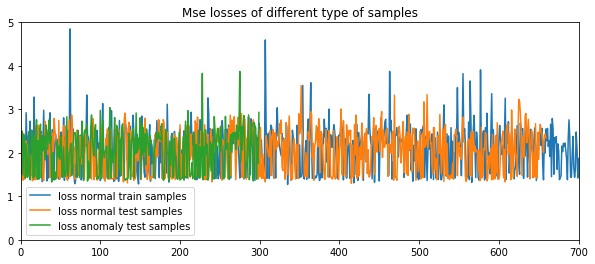

In [39]:
#Plot the losses
plt.figure(figsize=(10,4))
plt.plot(liste_train, label='loss normal train samples')
plt.plot(liste_test, label='loss normal test samples')
plt.plot(liste_anomaly, label='loss anomaly test samples')
plt.title('Mse losses of different type of samples')
plt.legend()
plt.xlim(0,700)
plt.ylim(0,5)
plt.show()

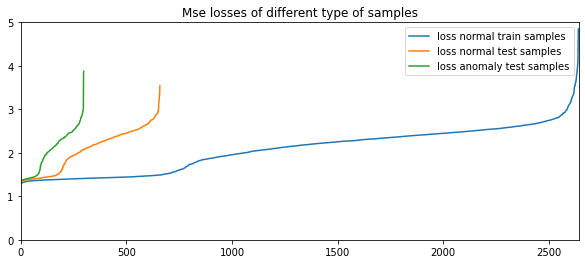

In [40]:
#Plot the losses
plt.figure(figsize=(10,4))
plt.plot(np.sort(liste_train), label='loss normal train samples')
plt.plot(np.sort(liste_test), label='loss normal test samples')
plt.plot(np.sort(liste_anomaly), label='loss anomaly test samples')
plt.title('Mse losses of different type of samples')
plt.legend()
plt.xlim(0,2640)
plt.ylim(0,5)
plt.show()

#### pas satisfaisant